# Collaborative Filtering Methods

In [1]:
# data analysis and wrangling
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# functions to test
from gradientDescent import gradientDescent
from alternatingLeastSquares import ALS
from lineSearchAlgorithm import lineSearch
from cost_functions import get_Ju_and_DJu, get_Ja_and_DJa
from aux_functions import initializeQ, initializeP
from accuracyMetrics import RMSE

## Sample Data
We create a simple $5\times4$ interactions matrix to test our algorithms.

In [2]:
R0 = np.array(
    [
        [5, 1, np.NAN, 4],
        [np.NAN, 9, np.NAN, 2],
        [9, 2, 1, np.NAN],
        [6, np.NAN, 7, 4],
        [np.NAN, 4, 7, 5],
    ]
)

R = R0

# Calculate the mean and standard deviation of each column (axis 0)
mean = np.nanmean(R)

# Standardize the matrix
R = (R - mean)

m, n = R.shape

We define the range $f$ for the matrices $Q$ and $P$ that will approximate $R$.

In [3]:
f = 5

We initialize $Q$ and $P$ with values from a standard normal random variable keeping a constant seed for consistent results.

In [4]:
# Seed
np.random.seed(43)

# Q and P initilization
Q = initializeQ(R.shape[0], f)
P = initializeP(R.shape[1], f)

## Line Search Test

In [5]:
Ju, DJu = get_Ju_and_DJu(R, P, f)
Q = Q.flatten()
p_k = -DJu(Q)
alpha = lineSearch(Ju, DJu, Q, p_k)
alpha

0.125

## Optimizing $Ju$ using Gradient Descent with Line Search

In [6]:
tol = 1e-5
max_iter = 1e4

Ju, DJu = get_Ju_and_DJu(R, P, f)

Q = Q.flatten()
gradientDescentResults = gradientDescent(Ju, Q, DJu, tol, max_iter)
newQs = gradientDescentResults["x_values"]
Ju_values = gradientDescentResults["func_values"]

Calculating errors and $RMSE$

$$RMSE = \sqrt{\frac{\sum_{(u,j)}{e_{u,j}^2}}{\lvert E \rvert}}$$

In [7]:
RMSEs = []
for Q_k in newQs:
    Q_k = Q_k.reshape(R.shape[0],-1)
    errors = (Q_k @ P.T - R).flatten()

    # Check for NaN values using np.isnan()
    is_nan = np.isnan(errors)

    # Use boolean indexing to filter out NaN values
    errors = errors[~is_nan]
    RMSEs.append(RMSE(errors))

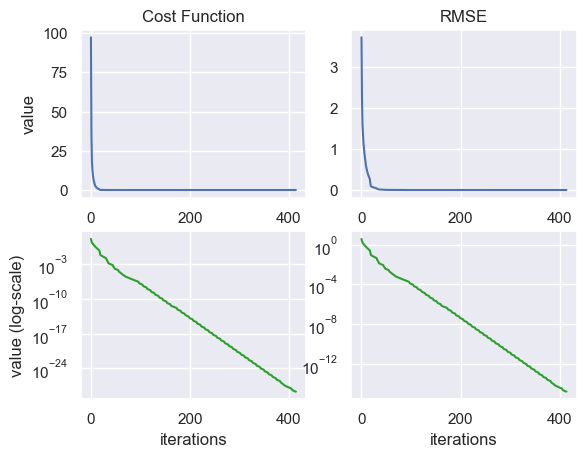

In [8]:
fig, axs = plt.subplots(2, 2)

axs[0, 0].plot(Ju_values)
axs[0, 0].set_title('Cost Function')
axs[0, 1].plot(RMSEs)
axs[0, 1].set_title('RMSE')
axs[1, 0].semilogy(Ju_values, 'tab:green')
axs[1, 1].semilogy(RMSEs, 'tab:green')

axs[0,0].set(xlabel='iterations', ylabel='value')
axs[1,0].set(xlabel='iterations', ylabel='value (log-scale)')
axs[1,1].set(xlabel='iterations')

plt.show()

## Testing ALS method for collaborative filtering

In [9]:
np.random.seed(43)
f = 4
alternations = 1000
tol = 1e-2
max_iter = 1e1

als_result = ALS(R, f, alternations=alternations, tol=tol, max_iter=max_iter)

In [10]:
newQ = als_result["Q"]
newP = als_result["P"]
Ju_values = als_result["Ju_values"]
Ja_values = als_result["Ja_values"]
RMSEu_values = als_result["RMSEu_values"]
RMSEa_values = als_result["RMSEa_values"]

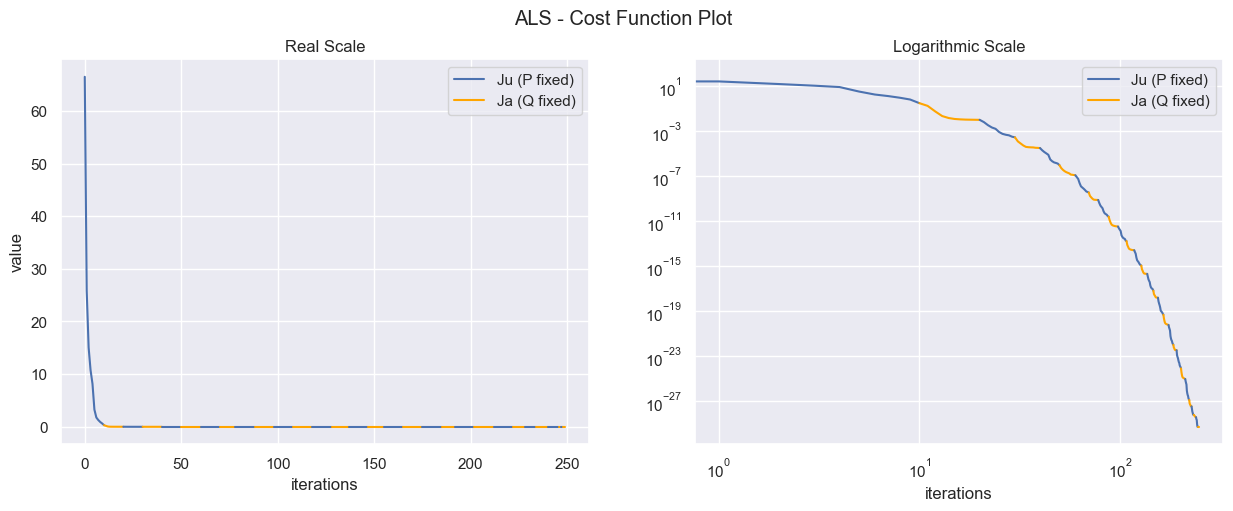

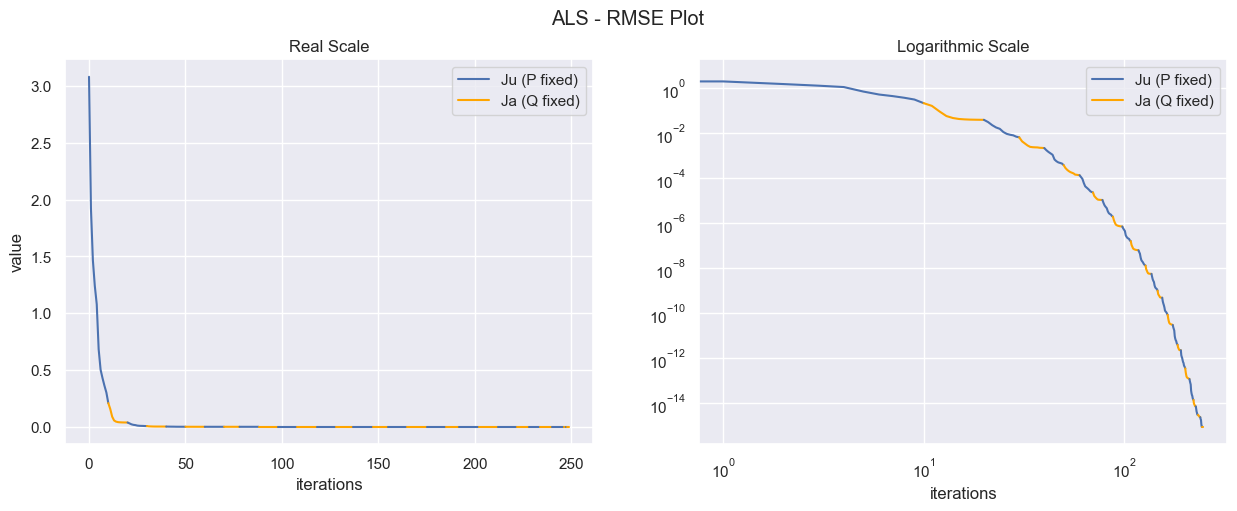

In [11]:

from plottingFunctions import plotALSResults
plotALSResults(Ju_values, Ja_values, "ALS - Cost Function Plot")
plotALSResults(RMSEu_values, RMSEa_values, "ALS - RMSE Plot")

## Regularization

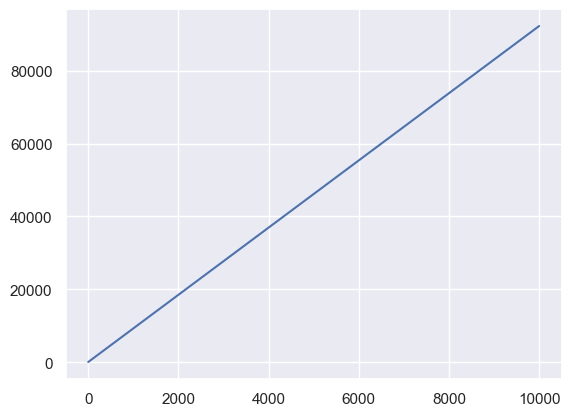

In [20]:
# Seed
np.random.seed(43)

# Q and P initilization
f=4
Q_0 = initializeQ(R.shape[0], f)
P_0 = initializeP(R.shape[1], f)

lambs = np.append(0,(np.logspace(0, 4, 100)))
Ju_values = []
for lamb in lambs:
    Ju, _ = get_Ju_and_DJu(R, P_0, f, lamb,)
    Ju_values.append(Ju(Q_0.flatten()))
fig, ax = plt.subplots()
ax.plot(lambs, Ju_values)
plt.show()

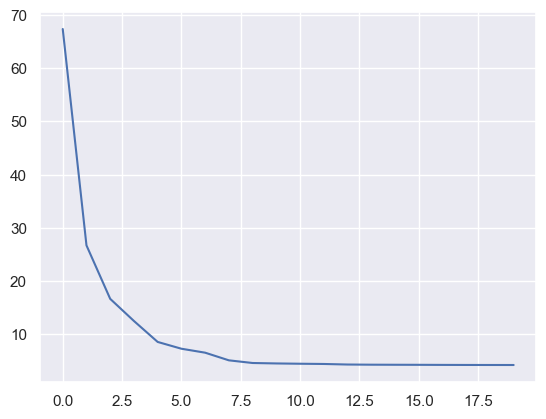

In [21]:
tol = 1e-3
max_iter = 1e3
lamb = 0.1
fig, ax = plt.subplots()

Ju, DJu = get_Ju_and_DJu(R, P_0, f, lamb)
Q_0 = Q_0.flatten()
gradientDescentResults = gradientDescent(Ju, Q_0, DJu, tol, max_iter)
Ju_values = gradientDescentResults["func_values"]
ax.plot(Ju_values)

plt.show()

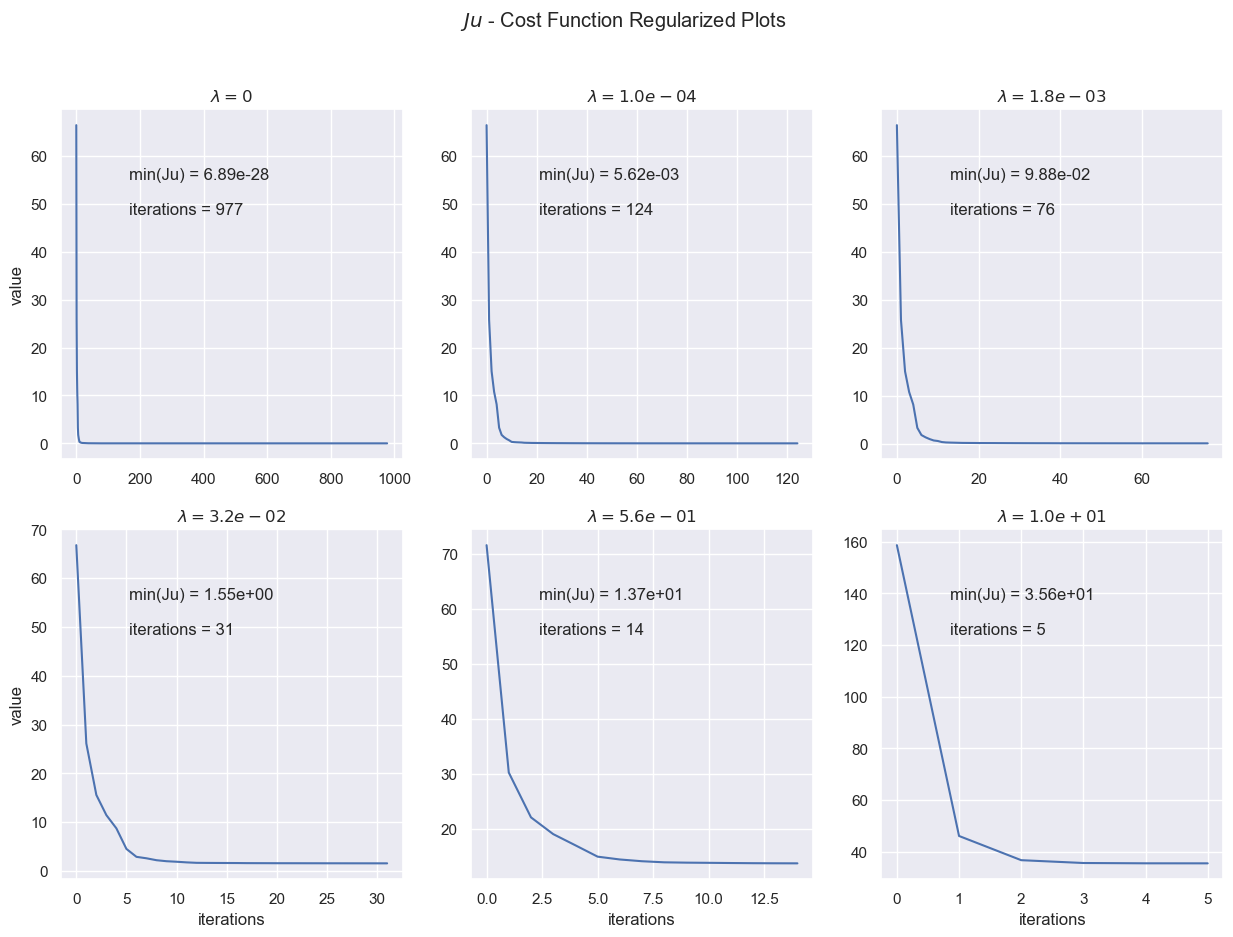

In [22]:
tol = 1e-3
max_iter = 1e4

lambs = np.append(0, (np.logspace(-4, 1, 5)))

plots_per_row = 3
fig, axs = plt.subplots(
    int(np.ceil(len(lambs) / plots_per_row)),
    min(len(lambs), plots_per_row),
    figsize=(15, 10),
)
fig.suptitle(r"$Ju$ - Cost Function Regularized Plots")

for i, lamb in enumerate(lambs):
    Ju, DJu = get_Ju_and_DJu(R, P_0, f, lamb)
    Q_0 = Q_0.flatten()
    gradientDescentResults = gradientDescent(Ju, Q_0, DJu, tol, max_iter)
    Ju_values = gradientDescentResults["func_values"]
    x, y = i // plots_per_row, i % plots_per_row
    axs[x, y].plot(Ju_values)
    axs[x, y].set_title(
        r"$\lambda = {:.1e}$".format(lamb) if lamb != 0 else r"$\lambda = 0$"
    )
    if y == 0:
        axs[x, y].set(ylabel="value")
    if x == int(np.ceil(len(lambs) / plots_per_row)) - 1:
        axs[x, y].set(xlabel="iterations")

    text = "min(Ju) = {:.2e} \n\niterations = {}".format(
        Ju_values[-1], len(Ju_values) - 1
    )
    axs[x, y].text(0.2, 0.7, text, transform=axs[x, y].transAxes)

plt.show()